In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# 주택 가격 예측

In [2]:
housing = pd.read_csv('./data/housing.csv')

## EDA

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


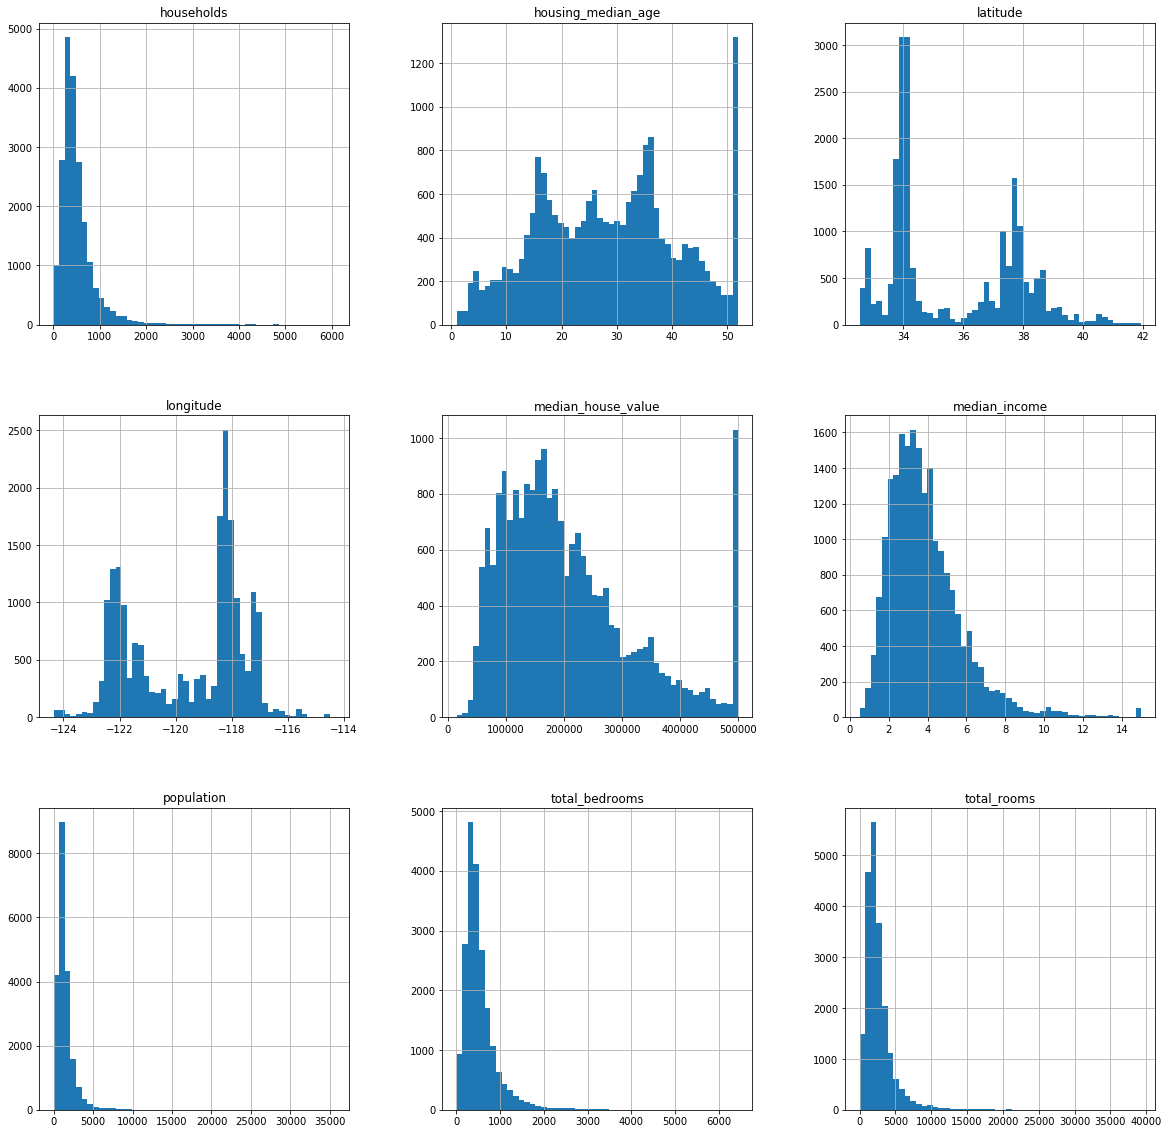

In [6]:
housing.hist(bins =50, figsize=(20,20))
plt.show()

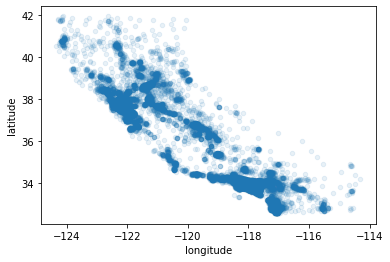

In [7]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
plt.show()

In [8]:
housing.corr()['median_house_value'].sort_values()

latitude             -0.144160
longitude            -0.045967
population           -0.024650
total_bedrooms        0.049686
households            0.065843
housing_median_age    0.105623
total_rooms           0.134153
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

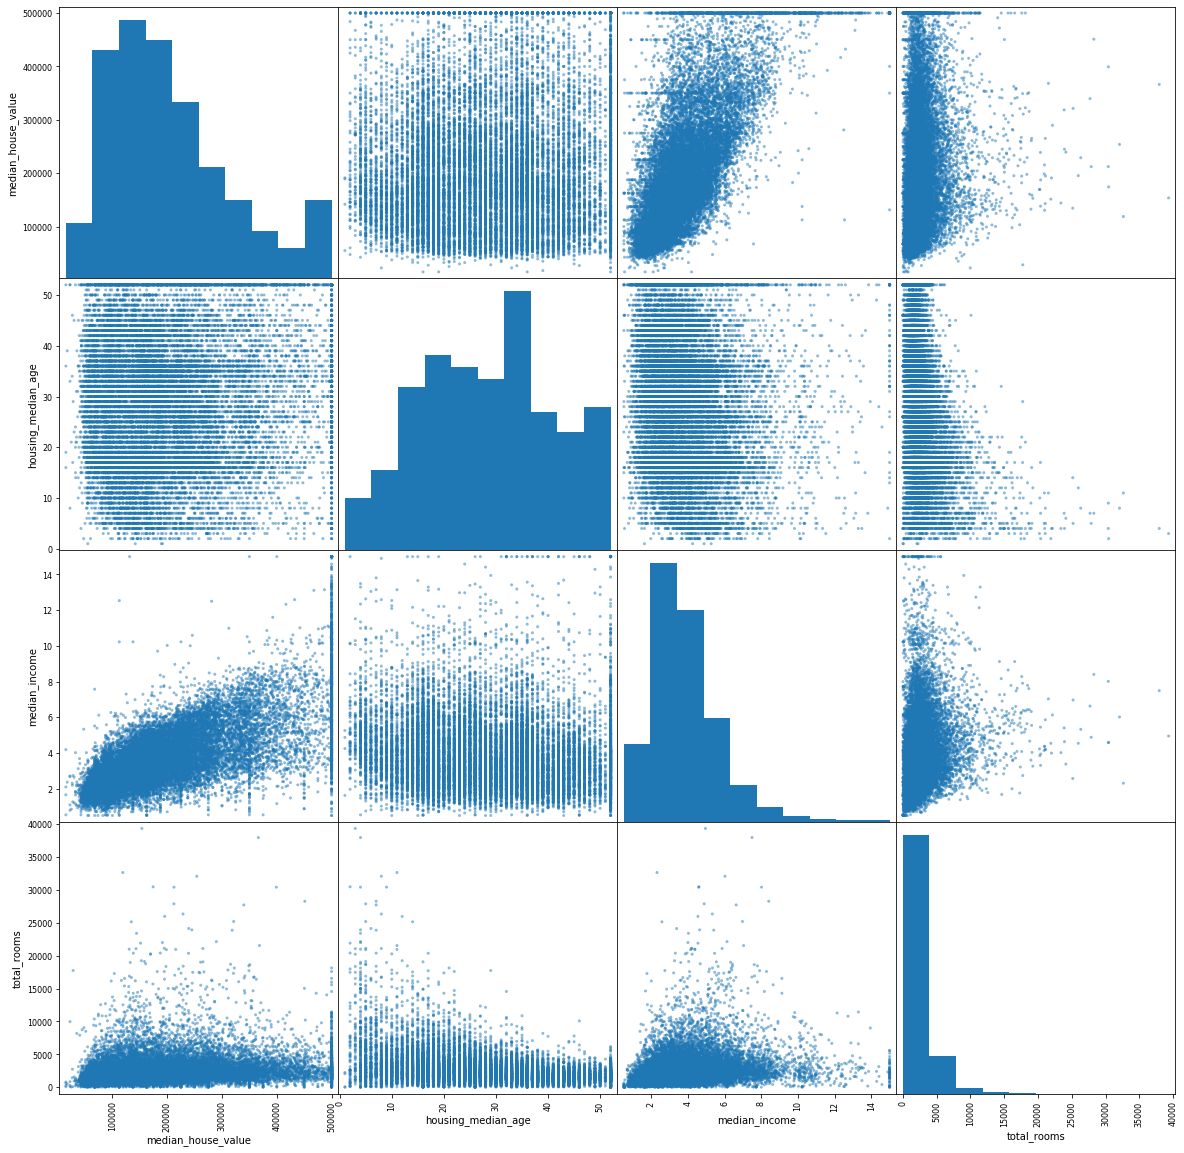

In [9]:
pd.plotting.scatter_matrix(
    housing[['median_house_value', 'housing_median_age', 'median_income', 'total_rooms']], figsize=(20, 20))
plt.show()

## 전처리

In [10]:
# NaN 처리
housing = housing[~ housing.total_bedrooms.isnull()]

In [11]:
# ocean_proximity one-hot 인코딩
housing = pd.get_dummies(housing)

# label 인코딩의 경우
# sklearn.preprocessing.LabelEncoder.fit_transform(시리즈)

In [12]:
# 의미 있는 칼럼으로 변경
housing['rooms_per_hh'] = housing.total_rooms/housing.households
housing['bedrooms_per_hh'] = housing.total_bedrooms/housing.households
housing['population_per_hh'] = housing.population/housing.households

housing.drop(['total_rooms','total_bedrooms','population'], axis=1, inplace=True)

In [13]:
# outlier로 추측되는 것 제외
housing = housing[housing.housing_median_age != 52]
housing = housing[housing.median_house_value != housing.median_house_value.max()]

## train test set

In [42]:
X = housing.drop('median_house_value', axis=1)
y = housing.median_house_value

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

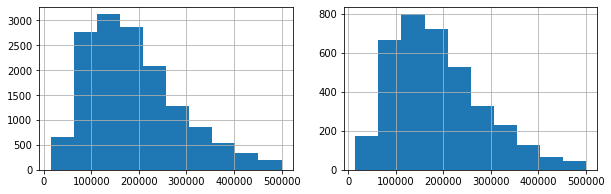

In [44]:
plt.figure(figsize=(10,3))

plt.subplot(121)
y_train.hist()

plt.subplot(122)
y_test.hist()

plt.show() # y의 train와 test 분포가 비슷하게 분리해야 함

In [45]:
# 인위적으로 비슷하게 분리하는 방법
    # housing = housing.reset_index()
    # housing.drop('index', axis=1, inplace=True)
    # 
    # income_cat = pd.qcut(housing.median_income,10)
    # from sklearn.preprocessing import LabelEncoder
    # le = LabelEncoder()
    # housing['income_cat'] = le.fit_transform(income_cat)
    # 
    # from sklearn.model_selection import StratifiedShuffleSplit
    # ss = StratifiedShuffleSplit(test_size=0.2)
    # for train_idx, test_idx in ss.split(housing, housing.income_cat):
    #     train_set = housing.iloc[train_idx]
    #     test_set = housing.iloc[test_idx]
    #     
    # train_set.drop('income_cat', axis=1, inplace =True)
    # test_set.drop('income_cat', axis=1, inplace =True)
    # 
    # X_train = train_set.drop('median_house_value', axis=1)
    # y_trian = train_set.median_house_value
    # X_test = test_set.drop('median_house_value', axis=1)
    # X_test = test_set.median_house_value

## 학습 및 평가

In [46]:
rf_reg = RandomForestRegressor(n_estimators=100)
rf_params ={
    'n_estimators':[3,5,7],
    'max_depth':[3,5]
}
grid_rf = GridSearchCV(rf_reg, param_grid=rf_params, cv=5,\
                       scoring='neg_mean_squared_error')

In [47]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [48]:
grid_rf.score(X_test, y_test)

-2993956017.971122

In [49]:
rf_mse = mean_squared_error(y_test, grid_rf.predict(X_test))
np.sqrt(rf_mse)

54717.05417848371

## 실제와 결과값의 차이 그래프

In [50]:
result = pd.concat([y_test.reset_index(), pd.Series(grid_rf.predict(X_test))], axis=1)

In [51]:
result.drop('index', axis=1, inplace=True)

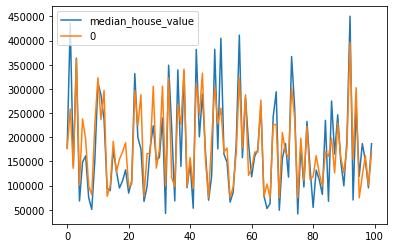

In [52]:
result[:100].plot()
plt.show()

# Xgboost로 예측

In [53]:
from xgboost import XGBRegressor

In [59]:
# ValueError: feature_names may not contain [, ] or < 문제 처리
X_train.columns = ['longitude', 'latitude', 'housing_median_age', 'households',
       'median_income', 'ocean_proximity_1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN', 'rooms_per_hh', 'bedrooms_per_hh',
       'population_per_hh', 'income_cat']

X_test.columns= ['longitude', 'latitude', 'housing_median_age', 'households',
       'median_income', 'ocean_proximity_1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN', 'rooms_per_hh', 'bedrooms_per_hh',
       'population_per_hh', 'income_cat']

In [54]:
xgb_rg = XGBRegressor()

In [66]:
xgb_params={
    'n_estimators':[200,400],
    'learning_rate':[0.1,0.2]
}

grid_xgb=GridSearchCV(xgb_rg, param_grid=xgb_params, cv=5, scoring='neg_mean_squared_error')

evals = [(X_test, y_test)]
grid_xgb.fit(X_train, y_train, eval_set=evals, eval_metric='logloss')

[11:44:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-logloss:-6.95783e+06
[1]	validation_0-logloss:-6.95783e+06
[2]	validation_0-logloss:-6.95783e+06
[3]	validation_0-logloss:-6.95783e+06
[4]	validation_0-logloss:-6.95783e+06
[5]	validation_0-logloss:-6.95783e+06
[6]	validation_0-logloss:-6.95783e+06
[7]	validation_0-logloss:-6.95783e+06
[8]	validation_0-logloss:-6.95783e+06
[9]	validation_0-logloss:-6.95783e+06
[10]	validation_0-logloss:-6.95783e+06
[11]	validation_0-logloss:-6.95783e+06
[12]	validation_0-logloss:-6.95783e+06
[13]	validation_0-logloss:-6.95783e+06
[14]	validation_0-logloss:-6.95783e+06
[15]	validation_0-logloss:-6.95783e+06
[16]	validation_0-logloss:-6.95783e+06
[17]	validation_0-logloss:-6.95783e+06
[18]	validation_0-logloss:-6.95783e+06
[19]	validation_0-logloss:-6.95783e+06
[20]	validation_0-logloss:-6.95783e+06
[21]	validation_0-logloss:-6.95783e+06
[22]	validation_0-logloss:-6.95783e+

[2]	validation_0-logloss:-6.95783e+06
[3]	validation_0-logloss:-6.95783e+06
[4]	validation_0-logloss:-6.95783e+06
[5]	validation_0-logloss:-6.95783e+06
[6]	validation_0-logloss:-6.95783e+06
[7]	validation_0-logloss:-6.95783e+06
[8]	validation_0-logloss:-6.95783e+06
[9]	validation_0-logloss:-6.95783e+06
[10]	validation_0-logloss:-6.95783e+06
[11]	validation_0-logloss:-6.95783e+06
[12]	validation_0-logloss:-6.95783e+06
[13]	validation_0-logloss:-6.95783e+06
[14]	validation_0-logloss:-6.95783e+06
[15]	validation_0-logloss:-6.95783e+06
[16]	validation_0-logloss:-6.95783e+06
[17]	validation_0-logloss:-6.95783e+06
[18]	validation_0-logloss:-6.95783e+06
[19]	validation_0-logloss:-6.95783e+06
[20]	validation_0-logloss:-6.95783e+06
[21]	validation_0-logloss:-6.95783e+06
[22]	validation_0-logloss:-6.95783e+06
[23]	validation_0-logloss:-6.95783e+06
[24]	validation_0-logloss:-6.95783e+06
[25]	validation_0-logloss:-6.95783e+06
[26]	validation_0-logloss:-6.95783e+06
[27]	validation_0-logloss:-6.9578

[7]	validation_0-logloss:-6.95783e+06
[8]	validation_0-logloss:-6.95783e+06
[9]	validation_0-logloss:-6.95783e+06
[10]	validation_0-logloss:-6.95783e+06
[11]	validation_0-logloss:-6.95783e+06
[12]	validation_0-logloss:-6.95783e+06
[13]	validation_0-logloss:-6.95783e+06
[14]	validation_0-logloss:-6.95783e+06
[15]	validation_0-logloss:-6.95783e+06
[16]	validation_0-logloss:-6.95783e+06
[17]	validation_0-logloss:-6.95783e+06
[18]	validation_0-logloss:-6.95783e+06
[19]	validation_0-logloss:-6.95783e+06
[20]	validation_0-logloss:-6.95783e+06
[21]	validation_0-logloss:-6.95783e+06
[22]	validation_0-logloss:-6.95783e+06
[23]	validation_0-logloss:-6.95783e+06
[24]	validation_0-logloss:-6.95783e+06
[25]	validation_0-logloss:-6.95783e+06
[26]	validation_0-logloss:-6.95783e+06
[27]	validation_0-logloss:-6.95783e+06
[28]	validation_0-logloss:-6.95783e+06
[29]	validation_0-logloss:-6.95783e+06
[30]	validation_0-logloss:-6.95783e+06
[31]	validation_0-logloss:-6.95783e+06
[32]	validation_0-logloss:-6

[12]	validation_0-logloss:-6.95783e+06
[13]	validation_0-logloss:-6.95783e+06
[14]	validation_0-logloss:-6.95783e+06
[15]	validation_0-logloss:-6.95783e+06
[16]	validation_0-logloss:-6.95783e+06
[17]	validation_0-logloss:-6.95783e+06
[18]	validation_0-logloss:-6.95783e+06
[19]	validation_0-logloss:-6.95783e+06
[20]	validation_0-logloss:-6.95783e+06
[21]	validation_0-logloss:-6.95783e+06
[22]	validation_0-logloss:-6.95783e+06
[23]	validation_0-logloss:-6.95783e+06
[24]	validation_0-logloss:-6.95783e+06
[25]	validation_0-logloss:-6.95783e+06
[26]	validation_0-logloss:-6.95783e+06
[27]	validation_0-logloss:-6.95783e+06
[28]	validation_0-logloss:-6.95783e+06
[29]	validation_0-logloss:-6.95783e+06
[30]	validation_0-logloss:-6.95783e+06
[31]	validation_0-logloss:-6.95783e+06
[32]	validation_0-logloss:-6.95783e+06
[33]	validation_0-logloss:-6.95783e+06
[34]	validation_0-logloss:-6.95783e+06
[35]	validation_0-logloss:-6.95783e+06
[36]	validation_0-logloss:-6.95783e+06
[37]	validation_0-logloss

[17]	validation_0-logloss:-6.95783e+06
[18]	validation_0-logloss:-6.95783e+06
[19]	validation_0-logloss:-6.95783e+06
[20]	validation_0-logloss:-6.95783e+06
[21]	validation_0-logloss:-6.95783e+06
[22]	validation_0-logloss:-6.95783e+06
[23]	validation_0-logloss:-6.95783e+06
[24]	validation_0-logloss:-6.95783e+06
[25]	validation_0-logloss:-6.95783e+06
[26]	validation_0-logloss:-6.95783e+06
[27]	validation_0-logloss:-6.95783e+06
[28]	validation_0-logloss:-6.95783e+06
[29]	validation_0-logloss:-6.95783e+06
[30]	validation_0-logloss:-6.95783e+06
[31]	validation_0-logloss:-6.95783e+06
[32]	validation_0-logloss:-6.95783e+06
[33]	validation_0-logloss:-6.95783e+06
[34]	validation_0-logloss:-6.95783e+06
[35]	validation_0-logloss:-6.95783e+06
[36]	validation_0-logloss:-6.95783e+06
[37]	validation_0-logloss:-6.95783e+06
[38]	validation_0-logloss:-6.95783e+06
[39]	validation_0-logloss:-6.95783e+06
[40]	validation_0-logloss:-6.95783e+06
[41]	validation_0-logloss:-6.95783e+06
[42]	validation_0-logloss

[22]	validation_0-logloss:-6.95783e+06
[23]	validation_0-logloss:-6.95783e+06
[24]	validation_0-logloss:-6.95783e+06
[25]	validation_0-logloss:-6.95783e+06
[26]	validation_0-logloss:-6.95783e+06
[27]	validation_0-logloss:-6.95783e+06
[28]	validation_0-logloss:-6.95783e+06
[29]	validation_0-logloss:-6.95783e+06
[30]	validation_0-logloss:-6.95783e+06
[31]	validation_0-logloss:-6.95783e+06
[32]	validation_0-logloss:-6.95783e+06
[33]	validation_0-logloss:-6.95783e+06
[34]	validation_0-logloss:-6.95783e+06
[35]	validation_0-logloss:-6.95783e+06
[36]	validation_0-logloss:-6.95783e+06
[37]	validation_0-logloss:-6.95783e+06
[38]	validation_0-logloss:-6.95783e+06
[39]	validation_0-logloss:-6.95783e+06
[40]	validation_0-logloss:-6.95783e+06
[41]	validation_0-logloss:-6.95783e+06
[42]	validation_0-logloss:-6.95783e+06
[43]	validation_0-logloss:-6.95783e+06
[44]	validation_0-logloss:-6.95783e+06
[45]	validation_0-logloss:-6.95783e+06
[46]	validation_0-logloss:-6.95783e+06
[47]	validation_0-logloss

[229]	validation_0-logloss:-6.95783e+06
[230]	validation_0-logloss:-6.95783e+06
[231]	validation_0-logloss:-6.95783e+06
[232]	validation_0-logloss:-6.95783e+06
[233]	validation_0-logloss:-6.95783e+06
[234]	validation_0-logloss:-6.95783e+06
[235]	validation_0-logloss:-6.95783e+06
[236]	validation_0-logloss:-6.95783e+06
[237]	validation_0-logloss:-6.95783e+06
[238]	validation_0-logloss:-6.95783e+06
[239]	validation_0-logloss:-6.95783e+06
[240]	validation_0-logloss:-6.95783e+06
[241]	validation_0-logloss:-6.95783e+06
[242]	validation_0-logloss:-6.95783e+06
[243]	validation_0-logloss:-6.95783e+06
[244]	validation_0-logloss:-6.95783e+06
[245]	validation_0-logloss:-6.95783e+06
[246]	validation_0-logloss:-6.95783e+06
[247]	validation_0-logloss:-6.95783e+06
[248]	validation_0-logloss:-6.95783e+06
[249]	validation_0-logloss:-6.95783e+06
[250]	validation_0-logloss:-6.95783e+06
[251]	validation_0-logloss:-6.95783e+06
[252]	validation_0-logloss:-6.95783e+06
[253]	validation_0-logloss:-6.95783e+06


[32]	validation_0-logloss:-6.95783e+06
[33]	validation_0-logloss:-6.95783e+06
[34]	validation_0-logloss:-6.95783e+06
[35]	validation_0-logloss:-6.95783e+06
[36]	validation_0-logloss:-6.95783e+06
[37]	validation_0-logloss:-6.95783e+06
[38]	validation_0-logloss:-6.95783e+06
[39]	validation_0-logloss:-6.95783e+06
[40]	validation_0-logloss:-6.95783e+06
[41]	validation_0-logloss:-6.95783e+06
[42]	validation_0-logloss:-6.95783e+06
[43]	validation_0-logloss:-6.95783e+06
[44]	validation_0-logloss:-6.95783e+06
[45]	validation_0-logloss:-6.95783e+06
[46]	validation_0-logloss:-6.95783e+06
[47]	validation_0-logloss:-6.95783e+06
[48]	validation_0-logloss:-6.95783e+06
[49]	validation_0-logloss:-6.95783e+06
[50]	validation_0-logloss:-6.95783e+06
[51]	validation_0-logloss:-6.95783e+06
[52]	validation_0-logloss:-6.95783e+06
[53]	validation_0-logloss:-6.95783e+06
[54]	validation_0-logloss:-6.95783e+06
[55]	validation_0-logloss:-6.95783e+06
[56]	validation_0-logloss:-6.95783e+06
[57]	validation_0-logloss

[239]	validation_0-logloss:-6.95783e+06
[240]	validation_0-logloss:-6.95783e+06
[241]	validation_0-logloss:-6.95783e+06
[242]	validation_0-logloss:-6.95783e+06
[243]	validation_0-logloss:-6.95783e+06
[244]	validation_0-logloss:-6.95783e+06
[245]	validation_0-logloss:-6.95783e+06
[246]	validation_0-logloss:-6.95783e+06
[247]	validation_0-logloss:-6.95783e+06
[248]	validation_0-logloss:-6.95783e+06
[249]	validation_0-logloss:-6.95783e+06
[250]	validation_0-logloss:-6.95783e+06
[251]	validation_0-logloss:-6.95783e+06
[252]	validation_0-logloss:-6.95783e+06
[253]	validation_0-logloss:-6.95783e+06
[254]	validation_0-logloss:-6.95783e+06
[255]	validation_0-logloss:-6.95783e+06
[256]	validation_0-logloss:-6.95783e+06
[257]	validation_0-logloss:-6.95783e+06
[258]	validation_0-logloss:-6.95783e+06
[259]	validation_0-logloss:-6.95783e+06
[260]	validation_0-logloss:-6.95783e+06
[261]	validation_0-logloss:-6.95783e+06
[262]	validation_0-logloss:-6.95783e+06
[263]	validation_0-logloss:-6.95783e+06


[43]	validation_0-logloss:-6.95783e+06
[44]	validation_0-logloss:-6.95783e+06
[45]	validation_0-logloss:-6.95783e+06
[46]	validation_0-logloss:-6.95783e+06
[47]	validation_0-logloss:-6.95783e+06
[48]	validation_0-logloss:-6.95783e+06
[49]	validation_0-logloss:-6.95783e+06
[50]	validation_0-logloss:-6.95783e+06
[51]	validation_0-logloss:-6.95783e+06
[52]	validation_0-logloss:-6.95783e+06
[53]	validation_0-logloss:-6.95783e+06
[54]	validation_0-logloss:-6.95783e+06
[55]	validation_0-logloss:-6.95783e+06
[56]	validation_0-logloss:-6.95783e+06
[57]	validation_0-logloss:-6.95783e+06
[58]	validation_0-logloss:-6.95783e+06
[59]	validation_0-logloss:-6.95783e+06
[60]	validation_0-logloss:-6.95783e+06
[61]	validation_0-logloss:-6.95783e+06
[62]	validation_0-logloss:-6.95783e+06
[63]	validation_0-logloss:-6.95783e+06
[64]	validation_0-logloss:-6.95783e+06
[65]	validation_0-logloss:-6.95783e+06
[66]	validation_0-logloss:-6.95783e+06
[67]	validation_0-logloss:-6.95783e+06
[68]	validation_0-logloss

[250]	validation_0-logloss:-6.95783e+06
[251]	validation_0-logloss:-6.95783e+06
[252]	validation_0-logloss:-6.95783e+06
[253]	validation_0-logloss:-6.95783e+06
[254]	validation_0-logloss:-6.95783e+06
[255]	validation_0-logloss:-6.95783e+06
[256]	validation_0-logloss:-6.95783e+06
[257]	validation_0-logloss:-6.95783e+06
[258]	validation_0-logloss:-6.95783e+06
[259]	validation_0-logloss:-6.95783e+06
[260]	validation_0-logloss:-6.95783e+06
[261]	validation_0-logloss:-6.95783e+06
[262]	validation_0-logloss:-6.95783e+06
[263]	validation_0-logloss:-6.95783e+06
[264]	validation_0-logloss:-6.95783e+06
[265]	validation_0-logloss:-6.95783e+06
[266]	validation_0-logloss:-6.95783e+06
[267]	validation_0-logloss:-6.95783e+06
[268]	validation_0-logloss:-6.95783e+06
[269]	validation_0-logloss:-6.95783e+06
[270]	validation_0-logloss:-6.95783e+06
[271]	validation_0-logloss:-6.95783e+06
[272]	validation_0-logloss:-6.95783e+06
[273]	validation_0-logloss:-6.95783e+06
[274]	validation_0-logloss:-6.95783e+06


[54]	validation_0-logloss:-6.95783e+06
[55]	validation_0-logloss:-6.95783e+06
[56]	validation_0-logloss:-6.95783e+06
[57]	validation_0-logloss:-6.95783e+06
[58]	validation_0-logloss:-6.95783e+06
[59]	validation_0-logloss:-6.95783e+06
[60]	validation_0-logloss:-6.95783e+06
[61]	validation_0-logloss:-6.95783e+06
[62]	validation_0-logloss:-6.95783e+06
[63]	validation_0-logloss:-6.95783e+06
[64]	validation_0-logloss:-6.95783e+06
[65]	validation_0-logloss:-6.95783e+06
[66]	validation_0-logloss:-6.95783e+06
[67]	validation_0-logloss:-6.95783e+06
[68]	validation_0-logloss:-6.95783e+06
[69]	validation_0-logloss:-6.95783e+06
[70]	validation_0-logloss:-6.95783e+06
[71]	validation_0-logloss:-6.95783e+06
[72]	validation_0-logloss:-6.95783e+06
[73]	validation_0-logloss:-6.95783e+06
[74]	validation_0-logloss:-6.95783e+06
[75]	validation_0-logloss:-6.95783e+06
[76]	validation_0-logloss:-6.95783e+06
[77]	validation_0-logloss:-6.95783e+06
[78]	validation_0-logloss:-6.95783e+06
[79]	validation_0-logloss

[260]	validation_0-logloss:-6.95783e+06
[261]	validation_0-logloss:-6.95783e+06
[262]	validation_0-logloss:-6.95783e+06
[263]	validation_0-logloss:-6.95783e+06
[264]	validation_0-logloss:-6.95783e+06
[265]	validation_0-logloss:-6.95783e+06
[266]	validation_0-logloss:-6.95783e+06
[267]	validation_0-logloss:-6.95783e+06
[268]	validation_0-logloss:-6.95783e+06
[269]	validation_0-logloss:-6.95783e+06
[270]	validation_0-logloss:-6.95783e+06
[271]	validation_0-logloss:-6.95783e+06
[272]	validation_0-logloss:-6.95783e+06
[273]	validation_0-logloss:-6.95783e+06
[274]	validation_0-logloss:-6.95783e+06
[275]	validation_0-logloss:-6.95783e+06
[276]	validation_0-logloss:-6.95783e+06
[277]	validation_0-logloss:-6.95783e+06
[278]	validation_0-logloss:-6.95783e+06
[279]	validation_0-logloss:-6.95783e+06
[280]	validation_0-logloss:-6.95783e+06
[281]	validation_0-logloss:-6.95783e+06
[282]	validation_0-logloss:-6.95783e+06
[283]	validation_0-logloss:-6.95783e+06
[284]	validation_0-logloss:-6.95783e+06


[64]	validation_0-logloss:-6.95783e+06
[65]	validation_0-logloss:-6.95783e+06
[66]	validation_0-logloss:-6.95783e+06
[67]	validation_0-logloss:-6.95783e+06
[68]	validation_0-logloss:-6.95783e+06
[69]	validation_0-logloss:-6.95783e+06
[70]	validation_0-logloss:-6.95783e+06
[71]	validation_0-logloss:-6.95783e+06
[72]	validation_0-logloss:-6.95783e+06
[73]	validation_0-logloss:-6.95783e+06
[74]	validation_0-logloss:-6.95783e+06
[75]	validation_0-logloss:-6.95783e+06
[76]	validation_0-logloss:-6.95783e+06
[77]	validation_0-logloss:-6.95783e+06
[78]	validation_0-logloss:-6.95783e+06
[79]	validation_0-logloss:-6.95783e+06
[80]	validation_0-logloss:-6.95783e+06
[81]	validation_0-logloss:-6.95783e+06
[82]	validation_0-logloss:-6.95783e+06
[83]	validation_0-logloss:-6.95783e+06
[84]	validation_0-logloss:-6.95783e+06
[85]	validation_0-logloss:-6.95783e+06
[86]	validation_0-logloss:-6.95783e+06
[87]	validation_0-logloss:-6.95783e+06
[88]	validation_0-logloss:-6.95783e+06
[89]	validation_0-logloss

[270]	validation_0-logloss:-6.95783e+06
[271]	validation_0-logloss:-6.95783e+06
[272]	validation_0-logloss:-6.95783e+06
[273]	validation_0-logloss:-6.95783e+06
[274]	validation_0-logloss:-6.95783e+06
[275]	validation_0-logloss:-6.95783e+06
[276]	validation_0-logloss:-6.95783e+06
[277]	validation_0-logloss:-6.95783e+06
[278]	validation_0-logloss:-6.95783e+06
[279]	validation_0-logloss:-6.95783e+06
[280]	validation_0-logloss:-6.95783e+06
[281]	validation_0-logloss:-6.95783e+06
[282]	validation_0-logloss:-6.95783e+06
[283]	validation_0-logloss:-6.95783e+06
[284]	validation_0-logloss:-6.95783e+06
[285]	validation_0-logloss:-6.95783e+06
[286]	validation_0-logloss:-6.95783e+06
[287]	validation_0-logloss:-6.95783e+06
[288]	validation_0-logloss:-6.95783e+06
[289]	validation_0-logloss:-6.95783e+06
[290]	validation_0-logloss:-6.95783e+06
[291]	validation_0-logloss:-6.95783e+06
[292]	validation_0-logloss:-6.95783e+06
[293]	validation_0-logloss:-6.95783e+06
[294]	validation_0-logloss:-6.95783e+06


[75]	validation_0-logloss:-6.95783e+06
[76]	validation_0-logloss:-6.95783e+06
[77]	validation_0-logloss:-6.95783e+06
[78]	validation_0-logloss:-6.95783e+06
[79]	validation_0-logloss:-6.95783e+06
[80]	validation_0-logloss:-6.95783e+06
[81]	validation_0-logloss:-6.95783e+06
[82]	validation_0-logloss:-6.95783e+06
[83]	validation_0-logloss:-6.95783e+06
[84]	validation_0-logloss:-6.95783e+06
[85]	validation_0-logloss:-6.95783e+06
[86]	validation_0-logloss:-6.95783e+06
[87]	validation_0-logloss:-6.95783e+06
[88]	validation_0-logloss:-6.95783e+06
[89]	validation_0-logloss:-6.95783e+06
[90]	validation_0-logloss:-6.95783e+06
[91]	validation_0-logloss:-6.95783e+06
[92]	validation_0-logloss:-6.95783e+06
[93]	validation_0-logloss:-6.95783e+06
[94]	validation_0-logloss:-6.95783e+06
[95]	validation_0-logloss:-6.95783e+06
[96]	validation_0-logloss:-6.95783e+06
[97]	validation_0-logloss:-6.95783e+06
[98]	validation_0-logloss:-6.95783e+06
[99]	validation_0-logloss:-6.95783e+06
[100]	validation_0-loglos

[80]	validation_0-logloss:-6.95783e+06
[81]	validation_0-logloss:-6.95783e+06
[82]	validation_0-logloss:-6.95783e+06
[83]	validation_0-logloss:-6.95783e+06
[84]	validation_0-logloss:-6.95783e+06
[85]	validation_0-logloss:-6.95783e+06
[86]	validation_0-logloss:-6.95783e+06
[87]	validation_0-logloss:-6.95783e+06
[88]	validation_0-logloss:-6.95783e+06
[89]	validation_0-logloss:-6.95783e+06
[90]	validation_0-logloss:-6.95783e+06
[91]	validation_0-logloss:-6.95783e+06
[92]	validation_0-logloss:-6.95783e+06
[93]	validation_0-logloss:-6.95783e+06
[94]	validation_0-logloss:-6.95783e+06
[95]	validation_0-logloss:-6.95783e+06
[96]	validation_0-logloss:-6.95783e+06
[97]	validation_0-logloss:-6.95783e+06
[98]	validation_0-logloss:-6.95783e+06
[99]	validation_0-logloss:-6.95783e+06
[100]	validation_0-logloss:-6.95783e+06
[101]	validation_0-logloss:-6.95783e+06
[102]	validation_0-logloss:-6.95783e+06
[103]	validation_0-logloss:-6.95783e+06
[104]	validation_0-logloss:-6.95783e+06
[105]	validation_0-l

[85]	validation_0-logloss:-6.95783e+06
[86]	validation_0-logloss:-6.95783e+06
[87]	validation_0-logloss:-6.95783e+06
[88]	validation_0-logloss:-6.95783e+06
[89]	validation_0-logloss:-6.95783e+06
[90]	validation_0-logloss:-6.95783e+06
[91]	validation_0-logloss:-6.95783e+06
[92]	validation_0-logloss:-6.95783e+06
[93]	validation_0-logloss:-6.95783e+06
[94]	validation_0-logloss:-6.95783e+06
[95]	validation_0-logloss:-6.95783e+06
[96]	validation_0-logloss:-6.95783e+06
[97]	validation_0-logloss:-6.95783e+06
[98]	validation_0-logloss:-6.95783e+06
[99]	validation_0-logloss:-6.95783e+06
[100]	validation_0-logloss:-6.95783e+06
[101]	validation_0-logloss:-6.95783e+06
[102]	validation_0-logloss:-6.95783e+06
[103]	validation_0-logloss:-6.95783e+06
[104]	validation_0-logloss:-6.95783e+06
[105]	validation_0-logloss:-6.95783e+06
[106]	validation_0-logloss:-6.95783e+06
[107]	validation_0-logloss:-6.95783e+06
[108]	validation_0-logloss:-6.95783e+06
[109]	validation_0-logloss:-6.95783e+06
[110]	validatio

[90]	validation_0-logloss:-6.95783e+06
[91]	validation_0-logloss:-6.95783e+06
[92]	validation_0-logloss:-6.95783e+06
[93]	validation_0-logloss:-6.95783e+06
[94]	validation_0-logloss:-6.95783e+06
[95]	validation_0-logloss:-6.95783e+06
[96]	validation_0-logloss:-6.95783e+06
[97]	validation_0-logloss:-6.95783e+06
[98]	validation_0-logloss:-6.95783e+06
[99]	validation_0-logloss:-6.95783e+06
[100]	validation_0-logloss:-6.95783e+06
[101]	validation_0-logloss:-6.95783e+06
[102]	validation_0-logloss:-6.95783e+06
[103]	validation_0-logloss:-6.95783e+06
[104]	validation_0-logloss:-6.95783e+06
[105]	validation_0-logloss:-6.95783e+06
[106]	validation_0-logloss:-6.95783e+06
[107]	validation_0-logloss:-6.95783e+06
[108]	validation_0-logloss:-6.95783e+06
[109]	validation_0-logloss:-6.95783e+06
[110]	validation_0-logloss:-6.95783e+06
[111]	validation_0-logloss:-6.95783e+06
[112]	validation_0-logloss:-6.95783e+06
[113]	validation_0-logloss:-6.95783e+06
[114]	validation_0-logloss:-6.95783e+06
[115]	vali

[95]	validation_0-logloss:-6.95783e+06
[96]	validation_0-logloss:-6.95783e+06
[97]	validation_0-logloss:-6.95783e+06
[98]	validation_0-logloss:-6.95783e+06
[99]	validation_0-logloss:-6.95783e+06
[100]	validation_0-logloss:-6.95783e+06
[101]	validation_0-logloss:-6.95783e+06
[102]	validation_0-logloss:-6.95783e+06
[103]	validation_0-logloss:-6.95783e+06
[104]	validation_0-logloss:-6.95783e+06
[105]	validation_0-logloss:-6.95783e+06
[106]	validation_0-logloss:-6.95783e+06
[107]	validation_0-logloss:-6.95783e+06
[108]	validation_0-logloss:-6.95783e+06
[109]	validation_0-logloss:-6.95783e+06
[110]	validation_0-logloss:-6.95783e+06
[111]	validation_0-logloss:-6.95783e+06
[112]	validation_0-logloss:-6.95783e+06
[113]	validation_0-logloss:-6.95783e+06
[114]	validation_0-logloss:-6.95783e+06
[115]	validation_0-logloss:-6.95783e+06
[116]	validation_0-logloss:-6.95783e+06
[117]	validation_0-logloss:-6.95783e+06
[118]	validation_0-logloss:-6.95783e+06
[119]	validation_0-logloss:-6.95783e+06
[120]

[100]	validation_0-logloss:-6.95783e+06
[101]	validation_0-logloss:-6.95783e+06
[102]	validation_0-logloss:-6.95783e+06
[103]	validation_0-logloss:-6.95783e+06
[104]	validation_0-logloss:-6.95783e+06
[105]	validation_0-logloss:-6.95783e+06
[106]	validation_0-logloss:-6.95783e+06
[107]	validation_0-logloss:-6.95783e+06
[108]	validation_0-logloss:-6.95783e+06
[109]	validation_0-logloss:-6.95783e+06
[110]	validation_0-logloss:-6.95783e+06
[111]	validation_0-logloss:-6.95783e+06
[112]	validation_0-logloss:-6.95783e+06
[113]	validation_0-logloss:-6.95783e+06
[114]	validation_0-logloss:-6.95783e+06
[115]	validation_0-logloss:-6.95783e+06
[116]	validation_0-logloss:-6.95783e+06
[117]	validation_0-logloss:-6.95783e+06
[118]	validation_0-logloss:-6.95783e+06
[119]	validation_0-logloss:-6.95783e+06
[120]	validation_0-logloss:-6.95783e+06
[121]	validation_0-logloss:-6.95783e+06
[122]	validation_0-logloss:-6.95783e+06
[123]	validation_0-logloss:-6.95783e+06
[124]	validation_0-logloss:-6.95783e+06


[305]	validation_0-logloss:-6.95783e+06
[306]	validation_0-logloss:-6.95783e+06
[307]	validation_0-logloss:-6.95783e+06
[308]	validation_0-logloss:-6.95783e+06
[309]	validation_0-logloss:-6.95783e+06
[310]	validation_0-logloss:-6.95783e+06
[311]	validation_0-logloss:-6.95783e+06
[312]	validation_0-logloss:-6.95783e+06
[313]	validation_0-logloss:-6.95783e+06
[314]	validation_0-logloss:-6.95783e+06
[315]	validation_0-logloss:-6.95783e+06
[316]	validation_0-logloss:-6.95783e+06
[317]	validation_0-logloss:-6.95783e+06
[318]	validation_0-logloss:-6.95783e+06
[319]	validation_0-logloss:-6.95783e+06
[320]	validation_0-logloss:-6.95783e+06
[321]	validation_0-logloss:-6.95783e+06
[322]	validation_0-logloss:-6.95783e+06
[323]	validation_0-logloss:-6.95783e+06
[324]	validation_0-logloss:-6.95783e+06
[325]	validation_0-logloss:-6.95783e+06
[326]	validation_0-logloss:-6.95783e+06
[327]	validation_0-logloss:-6.95783e+06
[328]	validation_0-logloss:-6.95783e+06
[329]	validation_0-logloss:-6.95783e+06


[110]	validation_0-logloss:-6.95783e+06
[111]	validation_0-logloss:-6.95783e+06
[112]	validation_0-logloss:-6.95783e+06
[113]	validation_0-logloss:-6.95783e+06
[114]	validation_0-logloss:-6.95783e+06
[115]	validation_0-logloss:-6.95783e+06
[116]	validation_0-logloss:-6.95783e+06
[117]	validation_0-logloss:-6.95783e+06
[118]	validation_0-logloss:-6.95783e+06
[119]	validation_0-logloss:-6.95783e+06
[120]	validation_0-logloss:-6.95783e+06
[121]	validation_0-logloss:-6.95783e+06
[122]	validation_0-logloss:-6.95783e+06
[123]	validation_0-logloss:-6.95783e+06
[124]	validation_0-logloss:-6.95783e+06
[125]	validation_0-logloss:-6.95783e+06
[126]	validation_0-logloss:-6.95783e+06
[127]	validation_0-logloss:-6.95783e+06
[128]	validation_0-logloss:-6.95783e+06
[129]	validation_0-logloss:-6.95783e+06
[130]	validation_0-logloss:-6.95783e+06
[131]	validation_0-logloss:-6.95783e+06
[132]	validation_0-logloss:-6.95783e+06
[133]	validation_0-logloss:-6.95783e+06
[134]	validation_0-logloss:-6.95783e+06


[315]	validation_0-logloss:-6.95783e+06
[316]	validation_0-logloss:-6.95783e+06
[317]	validation_0-logloss:-6.95783e+06
[318]	validation_0-logloss:-6.95783e+06
[319]	validation_0-logloss:-6.95783e+06
[320]	validation_0-logloss:-6.95783e+06
[321]	validation_0-logloss:-6.95783e+06
[322]	validation_0-logloss:-6.95783e+06
[323]	validation_0-logloss:-6.95783e+06
[324]	validation_0-logloss:-6.95783e+06
[325]	validation_0-logloss:-6.95783e+06
[326]	validation_0-logloss:-6.95783e+06
[327]	validation_0-logloss:-6.95783e+06
[328]	validation_0-logloss:-6.95783e+06
[329]	validation_0-logloss:-6.95783e+06
[330]	validation_0-logloss:-6.95783e+06
[331]	validation_0-logloss:-6.95783e+06
[332]	validation_0-logloss:-6.95783e+06
[333]	validation_0-logloss:-6.95783e+06
[334]	validation_0-logloss:-6.95783e+06
[335]	validation_0-logloss:-6.95783e+06
[336]	validation_0-logloss:-6.95783e+06
[337]	validation_0-logloss:-6.95783e+06
[338]	validation_0-logloss:-6.95783e+06
[339]	validation_0-logloss:-6.95783e+06


[120]	validation_0-logloss:-6.95783e+06
[121]	validation_0-logloss:-6.95783e+06
[122]	validation_0-logloss:-6.95783e+06
[123]	validation_0-logloss:-6.95783e+06
[124]	validation_0-logloss:-6.95783e+06
[125]	validation_0-logloss:-6.95783e+06
[126]	validation_0-logloss:-6.95783e+06
[127]	validation_0-logloss:-6.95783e+06
[128]	validation_0-logloss:-6.95783e+06
[129]	validation_0-logloss:-6.95783e+06
[130]	validation_0-logloss:-6.95783e+06
[131]	validation_0-logloss:-6.95783e+06
[132]	validation_0-logloss:-6.95783e+06
[133]	validation_0-logloss:-6.95783e+06
[134]	validation_0-logloss:-6.95783e+06
[135]	validation_0-logloss:-6.95783e+06
[136]	validation_0-logloss:-6.95783e+06
[137]	validation_0-logloss:-6.95783e+06
[138]	validation_0-logloss:-6.95783e+06
[139]	validation_0-logloss:-6.95783e+06
[140]	validation_0-logloss:-6.95783e+06
[141]	validation_0-logloss:-6.95783e+06
[142]	validation_0-logloss:-6.95783e+06
[143]	validation_0-logloss:-6.95783e+06
[144]	validation_0-logloss:-6.95783e+06


[325]	validation_0-logloss:-6.95783e+06
[326]	validation_0-logloss:-6.95783e+06
[327]	validation_0-logloss:-6.95783e+06
[328]	validation_0-logloss:-6.95783e+06
[329]	validation_0-logloss:-6.95783e+06
[330]	validation_0-logloss:-6.95783e+06
[331]	validation_0-logloss:-6.95783e+06
[332]	validation_0-logloss:-6.95783e+06
[333]	validation_0-logloss:-6.95783e+06
[334]	validation_0-logloss:-6.95783e+06
[335]	validation_0-logloss:-6.95783e+06
[336]	validation_0-logloss:-6.95783e+06
[337]	validation_0-logloss:-6.95783e+06
[338]	validation_0-logloss:-6.95783e+06
[339]	validation_0-logloss:-6.95783e+06
[340]	validation_0-logloss:-6.95783e+06
[341]	validation_0-logloss:-6.95783e+06
[342]	validation_0-logloss:-6.95783e+06
[343]	validation_0-logloss:-6.95783e+06
[344]	validation_0-logloss:-6.95783e+06
[345]	validation_0-logloss:-6.95783e+06
[346]	validation_0-logloss:-6.95783e+06
[347]	validation_0-logloss:-6.95783e+06
[348]	validation_0-logloss:-6.95783e+06
[349]	validation_0-logloss:-6.95783e+06


[130]	validation_0-logloss:-6.95783e+06
[131]	validation_0-logloss:-6.95783e+06
[132]	validation_0-logloss:-6.95783e+06
[133]	validation_0-logloss:-6.95783e+06
[134]	validation_0-logloss:-6.95783e+06
[135]	validation_0-logloss:-6.95783e+06
[136]	validation_0-logloss:-6.95783e+06
[137]	validation_0-logloss:-6.95783e+06
[138]	validation_0-logloss:-6.95783e+06
[139]	validation_0-logloss:-6.95783e+06
[140]	validation_0-logloss:-6.95783e+06
[141]	validation_0-logloss:-6.95783e+06
[142]	validation_0-logloss:-6.95783e+06
[143]	validation_0-logloss:-6.95783e+06
[144]	validation_0-logloss:-6.95783e+06
[145]	validation_0-logloss:-6.95783e+06
[146]	validation_0-logloss:-6.95783e+06
[147]	validation_0-logloss:-6.95783e+06
[148]	validation_0-logloss:-6.95783e+06
[149]	validation_0-logloss:-6.95783e+06
[150]	validation_0-logloss:-6.95783e+06
[151]	validation_0-logloss:-6.95783e+06
[152]	validation_0-logloss:-6.95783e+06
[153]	validation_0-logloss:-6.95783e+06
[154]	validation_0-logloss:-6.95783e+06


[335]	validation_0-logloss:-6.95783e+06
[336]	validation_0-logloss:-6.95783e+06
[337]	validation_0-logloss:-6.95783e+06
[338]	validation_0-logloss:-6.95783e+06
[339]	validation_0-logloss:-6.95783e+06
[340]	validation_0-logloss:-6.95783e+06
[341]	validation_0-logloss:-6.95783e+06
[342]	validation_0-logloss:-6.95783e+06
[343]	validation_0-logloss:-6.95783e+06
[344]	validation_0-logloss:-6.95783e+06
[345]	validation_0-logloss:-6.95783e+06
[346]	validation_0-logloss:-6.95783e+06
[347]	validation_0-logloss:-6.95783e+06
[348]	validation_0-logloss:-6.95783e+06
[349]	validation_0-logloss:-6.95783e+06
[350]	validation_0-logloss:-6.95783e+06
[351]	validation_0-logloss:-6.95783e+06
[352]	validation_0-logloss:-6.95783e+06
[353]	validation_0-logloss:-6.95783e+06
[354]	validation_0-logloss:-6.95783e+06
[355]	validation_0-logloss:-6.95783e+06
[356]	validation_0-logloss:-6.95783e+06
[357]	validation_0-logloss:-6.95783e+06
[358]	validation_0-logloss:-6.95783e+06
[359]	validation_0-logloss:-6.95783e+06


[140]	validation_0-logloss:-6.95783e+06
[141]	validation_0-logloss:-6.95783e+06
[142]	validation_0-logloss:-6.95783e+06
[143]	validation_0-logloss:-6.95783e+06
[144]	validation_0-logloss:-6.95783e+06
[145]	validation_0-logloss:-6.95783e+06
[146]	validation_0-logloss:-6.95783e+06
[147]	validation_0-logloss:-6.95783e+06
[148]	validation_0-logloss:-6.95783e+06
[149]	validation_0-logloss:-6.95783e+06
[150]	validation_0-logloss:-6.95783e+06
[151]	validation_0-logloss:-6.95783e+06
[152]	validation_0-logloss:-6.95783e+06
[153]	validation_0-logloss:-6.95783e+06
[154]	validation_0-logloss:-6.95783e+06
[155]	validation_0-logloss:-6.95783e+06
[156]	validation_0-logloss:-6.95783e+06
[157]	validation_0-logloss:-6.95783e+06
[158]	validation_0-logloss:-6.95783e+06
[159]	validation_0-logloss:-6.95783e+06
[160]	validation_0-logloss:-6.95783e+06
[161]	validation_0-logloss:-6.95783e+06
[162]	validation_0-logloss:-6.95783e+06
[163]	validation_0-logloss:-6.95783e+06
[164]	validation_0-logloss:-6.95783e+06


[345]	validation_0-logloss:-6.95783e+06
[346]	validation_0-logloss:-6.95783e+06
[347]	validation_0-logloss:-6.95783e+06
[348]	validation_0-logloss:-6.95783e+06
[349]	validation_0-logloss:-6.95783e+06
[350]	validation_0-logloss:-6.95783e+06
[351]	validation_0-logloss:-6.95783e+06
[352]	validation_0-logloss:-6.95783e+06
[353]	validation_0-logloss:-6.95783e+06
[354]	validation_0-logloss:-6.95783e+06
[355]	validation_0-logloss:-6.95783e+06
[356]	validation_0-logloss:-6.95783e+06
[357]	validation_0-logloss:-6.95783e+06
[358]	validation_0-logloss:-6.95783e+06
[359]	validation_0-logloss:-6.95783e+06
[360]	validation_0-logloss:-6.95783e+06
[361]	validation_0-logloss:-6.95783e+06
[362]	validation_0-logloss:-6.95783e+06
[363]	validation_0-logloss:-6.95783e+06
[364]	validation_0-logloss:-6.95783e+06
[365]	validation_0-logloss:-6.95783e+06
[366]	validation_0-logloss:-6.95783e+06
[367]	validation_0-logloss:-6.95783e+06
[368]	validation_0-logloss:-6.95783e+06
[369]	validation_0-logloss:-6.95783e+06


[150]	validation_0-logloss:-6.95783e+06
[151]	validation_0-logloss:-6.95783e+06
[152]	validation_0-logloss:-6.95783e+06
[153]	validation_0-logloss:-6.95783e+06
[154]	validation_0-logloss:-6.95783e+06
[155]	validation_0-logloss:-6.95783e+06
[156]	validation_0-logloss:-6.95783e+06
[157]	validation_0-logloss:-6.95783e+06
[158]	validation_0-logloss:-6.95783e+06
[159]	validation_0-logloss:-6.95783e+06
[160]	validation_0-logloss:-6.95783e+06
[161]	validation_0-logloss:-6.95783e+06
[162]	validation_0-logloss:-6.95783e+06
[163]	validation_0-logloss:-6.95783e+06
[164]	validation_0-logloss:-6.95783e+06
[165]	validation_0-logloss:-6.95783e+06
[166]	validation_0-logloss:-6.95783e+06
[167]	validation_0-logloss:-6.95783e+06
[168]	validation_0-logloss:-6.95783e+06
[169]	validation_0-logloss:-6.95783e+06
[170]	validation_0-logloss:-6.95783e+06
[171]	validation_0-logloss:-6.95783e+06
[172]	validation_0-logloss:-6.95783e+06
[173]	validation_0-logloss:-6.95783e+06
[174]	validation_0-logloss:-6.95783e+06


[355]	validation_0-logloss:-6.95783e+06
[356]	validation_0-logloss:-6.95783e+06
[357]	validation_0-logloss:-6.95783e+06
[358]	validation_0-logloss:-6.95783e+06
[359]	validation_0-logloss:-6.95783e+06
[360]	validation_0-logloss:-6.95783e+06
[361]	validation_0-logloss:-6.95783e+06
[362]	validation_0-logloss:-6.95783e+06
[363]	validation_0-logloss:-6.95783e+06
[364]	validation_0-logloss:-6.95783e+06
[365]	validation_0-logloss:-6.95783e+06
[366]	validation_0-logloss:-6.95783e+06
[367]	validation_0-logloss:-6.95783e+06
[368]	validation_0-logloss:-6.95783e+06
[369]	validation_0-logloss:-6.95783e+06
[370]	validation_0-logloss:-6.95783e+06
[371]	validation_0-logloss:-6.95783e+06
[372]	validation_0-logloss:-6.95783e+06
[373]	validation_0-logloss:-6.95783e+06
[374]	validation_0-logloss:-6.95783e+06
[375]	validation_0-logloss:-6.95783e+06
[376]	validation_0-logloss:-6.95783e+06
[377]	validation_0-logloss:-6.95783e+06
[378]	validation_0-logloss:-6.95783e+06
[379]	validation_0-logloss:-6.95783e+06


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.2],
                         'n_estimators': [200, 400]},
             pre_dispatc

In [67]:
xgb_mse = mean_squared_error(y_test, grid_xgb.predict(X_test))
np.sqrt(xgb_mse)

42185.947729468826

# incremental Learning

즉 온라인 학습 등으로 추후 모델을 업데이트 하는 경우 : partial_fit

모든 모델이 존재하는 것이 아니므로 공식 API 참고

In [68]:
from sklearn.linear_model import SGDRegressor

In [71]:
sgd_rg = SGDRegressor(max_iter=1000, tol=0.001)

In [72]:
sgd_rg.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [80]:
sgd_mse = mean_squared_error(y_test, sgd_rg.predict(X_test))
np.sqrt(sgd_mse)

14134874252144.855

In [75]:
# 학습모델 피클 저장
import pickle
filename = './data/housing_predict.pkl'
with open(filename, 'wb') as file:
    pickle.dump(sgd_rg, file)

In [77]:
# 학습모델 피클 읽기
import pickle
filename = './data/housing_predict.pkl'
with open(filename, 'rb') as file:
    sgd_rg2 = pickle.load(file)

In [78]:
sgd_rg2.partial_fit(X_test, y_test)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [82]:
sgd2_mse = mean_squared_error(y_test, sgd_rg2.predict(X_test))
np.sqrt(sgd2_mse)

112158082981008.77